modified based on previous workshops by Jeff Johnston and Hanyu Li

In [6]:
from __future__ import division
from pycog import tasktools
import numpy as np

These RNNs have three layers (one could make more...) of time-varying "neurons": input units $\vec{u}(t)$, recurrent (hidden) units $\vec{r}(t)$, and output units $\vec{z}(t)$. The dynamics of the recurrent units are given by:
$$ \tau\frac{d\vec{x}}{dt} = -\vec{x} + W^{rec}\vec{r} + W^{in}\vec{u} + \sqrt{2\tau\sigma^{2}_{rec}}\vec{\xi} $$
$$ \vec{r} = [\vec{x}]_{+} $$
$$ \vec{z} = W^{out}\vec{r} $$
where $\vec{\xi}$ is a vector of independent gaussian RVs, and $[.]_{+}$ is the rectification function. 

<!-- First, let's decide that task that we want the network to perform. Let's start with something simple. How about a discrimination task? We want the network to signal via one output neuron if the input is less than some threshold $t$ and signal via a different output neuron if the input is greater than that value. To be clear, we have an input $x$ and two outputs $\vec{y}$, $y_{1}$ and $y_{2}$, we want our network to perform the function $f$, as in $\vec{y} = f(x)$, with $f$ defined as,

$ f(x) = 
\begin{cases}
[0, r]^{T} & x > t \\
[r, 0]^{T} & x \leq t
\end{cases}
$  -->

The task is figuring out the direction of the coherent motion

Let's decide what kind of network we want to use first. Two things are immediately clear: we need 100 input and two output neurons. 

How many neurons do we want for the hidden layer? 

In [208]:
# network details
nin = 100
n = 50
nout = 2

ei, exc, inh = tasktools.generate_ei(n)
ne = len(exc)
ni = len(inh)

# input
visual_input = 0 # label for the input index, we might want to add more later!
visual_exc = exc # all excitatory neurons in the hidden layer will receive visual input
# but note that the hidden units will not
cin = np.zeros((n, nin))#connectivity matrix
cin[visual_exc, :] = 1
baseline_input = .2 # noise

# output
left_resp = 0
right_resp = 1
cout = np.zeros((nout, n))#connectivity matrix
cout[:, exc] = 1 # output neurons both receive from all exc neurons

hi_resp = 1
lo_resp = 0

weights before training

Text(0.5, 1.0, 'output weights')

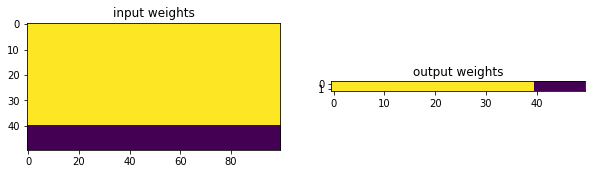

In [209]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,6))
plt.axis('off')
plt.subplot(121)
plt.imshow(cin)
plt.title('input weights')

plt.subplot(122)
plt.imshow(cout, aspect='equal')
plt.title('output weights')

Remember that if something is not working, you could always check the versions of your setups by the following and see if they are incompatible.

In [210]:
import sys
import matplotlib as mp
print ('Python version' + sys.version)
print ('matplotlib version' + mp.__version__)
print ('Numpy version ' + np.version.version)

Python version3.7.4 (default, Jul  8 2019, 18:31:06) 
[GCC 7.4.0]
matplotlib version3.0.3
Numpy version 1.16.1


Now we have a fairly clear trial structure. We want to choose $t$ such that $t$ is in the set of possible $x$ and then train the network to make the correct discrimination by giving it the correct output vector in training. This is done by the "generate_trial" function. First, let's consider how many conditions we have:
1. $x > t \rightarrow [0, r]^{T}$
2. $x \leq t \rightarrow [r, 0]^{T}$

Do we want anything else?

Something that appears to be useful in training is to assert the stimulus dependence of the network, by inserting trials on which the network is required to not robustly respond, that is, catch trials. 

The generate_file function has a strict input and output contract, but uses closures to store lots of variables declared globally before it. This simple version doesn't yet include cacth trials. Scroll down for the upgraded version.

In [211]:
import pdb

In [212]:
a = np.zeros((5,5))
a[2:] = np.random.uniform(size=(3,5))
a

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.74893637, 0.48417208, 0.26902998, 0.05625054, 0.97027476],
       [0.78088546, 0.91620994, 0.31508377, 0.30927066, 0.11116337],
       [0.06717029, 0.05421398, 0.68083351, 0.96583937, 0.80489943]])

In [395]:
dt = 20 # ms, we don't need to integrate with too much precision, especially for training -- we can plot with
        # higher resolution
tau = 100

catch_prob = 0
catch_len = 2000

def generate_trial(rng, dt, params):
    if np.random.uniform() < catch_prob:
        epochs = {'T': catch_len}
        t,e  = tasktools.get_epochs_idx(dt, epochs)
        trial = {'t': t, 'epochs': epochs}
        trial['info'] = {}
        trial['inputs'] = np.zeros((len(t), nin))
        trial['outputs'] = np.zeros((len(t), nout)) + lo_resp
        trial['mask'] = np.ones_like(trial['outputs'])
    else:
        
        
        fixation = 500
        sample = 2000
        wait = int(np.random.uniform(500, 1000))
        decision = 300
        T = fixation + sample + decision + wait
        epochs = {'fixation':(0, fixation),
                  'stimulus':(fixation, fixation + sample),
                  'wait': (fixation+sample, fixation+sample+wait),
                  'decision':(fixation + sample+wait, T),
                  'T':T}

    #     percent_coherent = np.random.uniform(low=0.125, high=1.0)
        percent_coherent = 0.5
        num_coherent = int(nin * percent_coherent)
#         num_coherent = 0

    #     steady = np.random.uniform() < 0.5
        go_left = np.random.uniform() < 0.5

        t, e = tasktools.get_epochs_idx(dt, epochs)
        trial = {'t':t, 'epochs':epochs}

        X = np.zeros((len(t), nin))

        coherent_inds = np.random.choice(list(range(nin)), replace=False, size=num_coherent)
        noncoherent_inds = [i for i in range(nin) if i not in coherent_inds]
        set_val = -np.pi if go_left else 0
        X[np.ix_(e['stimulus'],coherent_inds)] = set_val
        X[np.ix_(e['stimulus'], noncoherent_inds)] = np.random.uniform(
            low=-np.pi, 
            high=np.pi, 
            size=(len(e['stimulus']), nin-num_coherent))

        trial['inputs'] = X

        if go_left:
            choice = 1
        else:
            choice = 0

        Y = np.zeros((len(t), nout))
        M = np.zeros_like(Y)
        Y[e['fixation'], :] = lo_resp
        Y[e['decision'], int(go_left)] = hi_resp
        Y[e['decision'], 1-(go_left)] = lo_resp
        M[e['fixation']+e['decision'], :] = 1
        trial['outputs'] = Y
        trial['mask'] = M

        trial['info'] = {'choice': choice}
    return trial

# dt = 20 # ms
# tau = 100

# # Coherence level determines what percentage of the velocities move in the target direction
# # and what percentage move randomly
# coherence_level = 1.0

# fixation = 500
# sample = 400
# decision = 300
# T = fixation + sample + decision
# epochs = {"fixation": (0, fixation),
#           "stimulus": (fixation, fixation + sample),
#           "decision": (fixation + sample, T),
#           "T": T}


# def generate_trial(rng, dt, params):
#     """Generates data for one full trial"""
    
#     # Get the trial and epoch indices
#     t, e = tasktools.get_epochs_idx(dt, epochs)
#     trial = {"t":t, "epochs":epochs}
    
#     # Choose the direction for the coherent motion, and a subset of indices to move coherently
#     # parallel to the x axis. -1 is left, +1 is right.
#     direction_choice = np.random.uniform() > 0.5
# #     coherent_inds = np.random.choice(
# #         range(nin//2),
# #         replace=False,
# #         size=int(coherence_level*nin//2))
#     coherent_inds = np.array(list(range(coherence_level*nin//2)))
#     coherent_inds_x = coherent_inds
#     coherent_inds_x = coherent_inds * 2
#     coherent_inds_y = coherent_inds * 2 + 1
    
#     # Create the input sequence. All (v_x, v_y) are initialized randomly from a set of
#     # discrete choices, then the coherent ones are set.
#     X = np.zeros((len(t), nin))
#     X[e["stimulus"]] = 1
# #     X[e["stimulus"]] = np.random.choice(range(-2, 3), size=nin)
# #     X[np.ix_(e["stimulus"], coherent_inds_x)] = (direction_choice + 1) /2
# #     X[np.ix_(e["stimulus"], coherent_inds_y)] = 0

#     trial['inputs'] = X
        
#     Y = np.zeros((len(t), nout))
#     M = np.zeros_like(Y)
#     Y[e['fixation'], :] = lo_resp
#     Y[e["decision"]] = len(stimulus)
# #     Y[e['decision']] = lo_resp
# #     Y[e['decision'], int(direction_choice > 0)] = hi_resp
#     M[e['fixation']+e['decision'], :] = 1
#     trial['outputs'] = Y
#     trial['mask'] = M
    
# #     pdb.set_trace()
            
#     trial['info'] = {'choice': direction_choice}
    
#     return trial

Now, let's decide how we'll evaluate the performance of our network and when we'll tell our network to stop training.

In [396]:
# there are several ready-made performance metrics in the tasktools file, this is a two
# alternative forced choice task, so let's use that one
performance = tasktools.performance_2afc

# termination criterion
target_performance = 90
def terminate(performance_history):
    return np.mean(performance_history[-5:]) > target_performance

nconds = 2
n_validation = 100*nconds

All right, now we have all of the pieces that we need. Let's construct and then train the model. So far, we've had to do a lot of the work, now pycog will take over from us. 

In [397]:
from pycog import Model

model = Model(N=n, Nout=nout, Nin=nin, ei=ei, tau=tau, dt=dt,
              generate_trial=generate_trial, n_validation=n_validation, terminate=terminate,
              performance=performance)

In [398]:
seed = np.random.randint(0, 1000000)
model.train('test40.pkl', seed=seed, recover=True)#file shouldn't have existed in the folder already, or you will have error
#check the setting parameters to verify they are what you expected.
#refer to https://github.com/frsong/pycog for parameter tuning tricks if you have trouble with training

=> settings
   | GPU:                       no
   | init seed:                 248937
   | distribution (Win):        uniform
   | distribution (Wrec):       gamma
   | distribution (Wout):       uniform
   | Nin/N/Nout:                100/50/2
   | Dale's law:                E/I = 40/10
   | initial spectral radius:   1.50
   | train recurrent bias:      no
   | train output bias:         no
   | train initial conditions:  yes
   | sparseness (Wrec):         p = 0.98, p_plastic = 0.98
   | E/I positivity function:   rectify
   | hidden activation:         rectify
   | output activation/loss:    linear/squared
   | mode:                      batch
   | output mask:               yes
   | sigma_in:                  0.01
   | sigma_rec:                 0.15
   | rectify inputs:            True
   | gradient minibatch size:   20
   | validation minibatch size: 200
   | dt:                        20 ms
   | tau:                       100 ms
   | tau_in:                    100 ms
   | learn

| validation loss / RMSE / performance: 0.022337 / 0.149454 / 94.50
| Omega      (last iter) = 0.01410762
| grad. norm (last iter) = 12.83420753
| rho                    = 1.40850353
13500 updates - Jun 6 2020 4:29:56 PM (0 hrs 14 mins 9 secs elapsed)
| validation loss / RMSE / performance: 0.023711 / 0.153984 / 94.50
| Omega      (last iter) = 0.01294427
| grad. norm (last iter) = 10.36313438
| rho                    = 1.42020917
Termination criterion satisfied -- we'll call it a day.


In [400]:
from pycog import RNN
plot_dt = 1
#rnn = RNN('ramping_pathology.pkl', {'dt':plot_dt})
rnn = RNN('test40.pkl', {'dt':plot_dt})#importing the trained model

[ pycog.rnn.RNN ] 12500 updates, best error = 0.13621096, spectral radius = 1.39690316


Now let's run a single trial with the trained model

=> settings
   | dt:        1 ms
   | threshold: 0.0001
{'choice': 0, 'epochs': {'fixation': (0, 500), 'stimulus': (500, 2500), 'wait': (2500, 3316), 'decision': (3316, 3616), 'T': 3616}}


Text(0.5, 1.0, 'Neural activity in target vs. other direction')

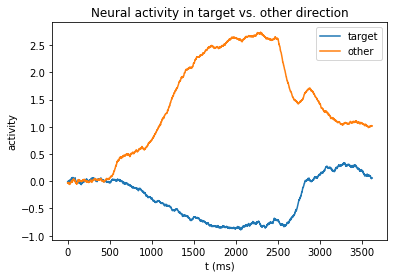

In [401]:
import matplotlib.pyplot as plt

%matplotlib inline
info = rnn.run(inputs=(generate_trial, {}), seed=np.random.randint(0, 10000))
print(info)
f = plt.figure()
corr_choice = info['choice']
ax = f.add_subplot(1, 1, 1)
ax.plot(rnn.t, rnn.z[corr_choice], label='target')
ax.plot(rnn.t, rnn.z[1 - corr_choice], label='other')
ax.legend()
ax.set_xlabel('t (ms)')
ax.set_ylabel('activity')
plt.title("Neural activity in target vs. other direction")

In [371]:
rnn.u[0].shape

(3301,)

Text(0, 0.5, 'Input/output values')

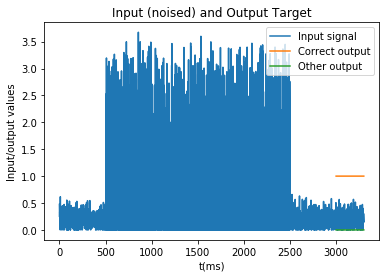

In [372]:
# plt.figure(figsize=(10,4.33))
plt.plot(range(0, 3301), rnn.u[0])
plt.plot(range(0, 3301), [None if t not in range(3000, 3301) else 1 for t in range(0, 3301)])
plt.plot(range(0, 3301), [None if t not in range(3000, 3301) else 0 for t in range(0, 3301)])
plt.title('Input (noised) and Output Target')
plt.legend(["Input signal", "Correct output", "Other output"])
plt.xlabel('t(ms)')
plt.ylabel("Input/output values")

In [373]:
rnn1 = rnn

ValueError: x and y must have same first dimension, but have shapes (3617,) and (3301,)

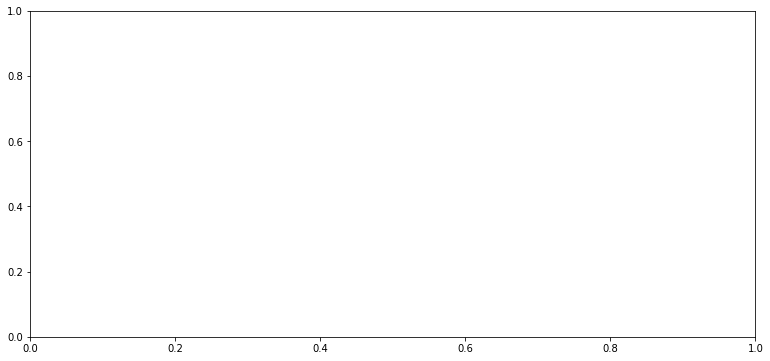

In [402]:
# plot idealized input/output
plt.figure(figsize=(13,6))
plt.plot(rnn.t, [None if t not in range(500, 2500) else np.pi for t in range(0, 3301)], label="Idealized input")
plt.plot(rnn.t, [None if t not in range(3000, 3301) else 1 for t in range(0, 3301)], label="Correct dir target")
plt.plot(rnn.t, [None if t not in range(3000, 3301) else 0 for t in rnn.t], label="Incorrect dir target")
plt.plot(rnn.t, rnn.z[0], label="Correct dir actual")
plt.plot(rnn.t, rnn.z[1], label="Incorrect dir actual")
plt.title('Neural activity for correct vs. incorrect direction (0% coherence)')
plt.legend()
plt.xlabel('t(ms)')
plt.ylabel("Input/output values")

In [226]:
rnn.u.shape

(100, 3301)

Text(0, 0.5, 'Firing rate')

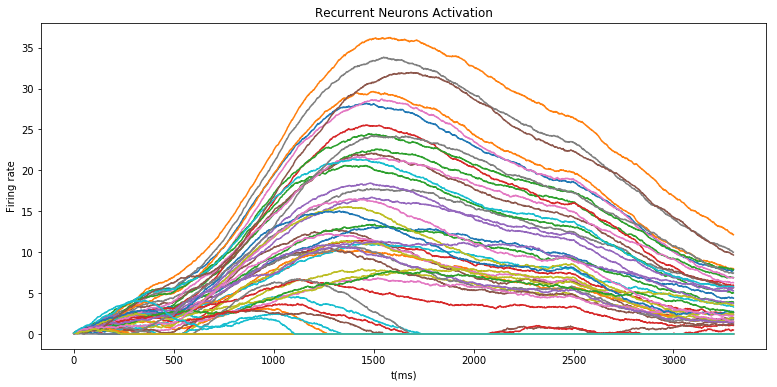

In [284]:
#plt.imshow(rnn.r, aspect='auto')
plt.figure(figsize=(13,6))

plt.plot(np.transpose(rnn.r))
plt.xlabel('t(ms)')
plt.title('Recurrent Neurons Activation')
plt.ylabel("Firing rate")

Text(0.5, 0, 't(ms)')

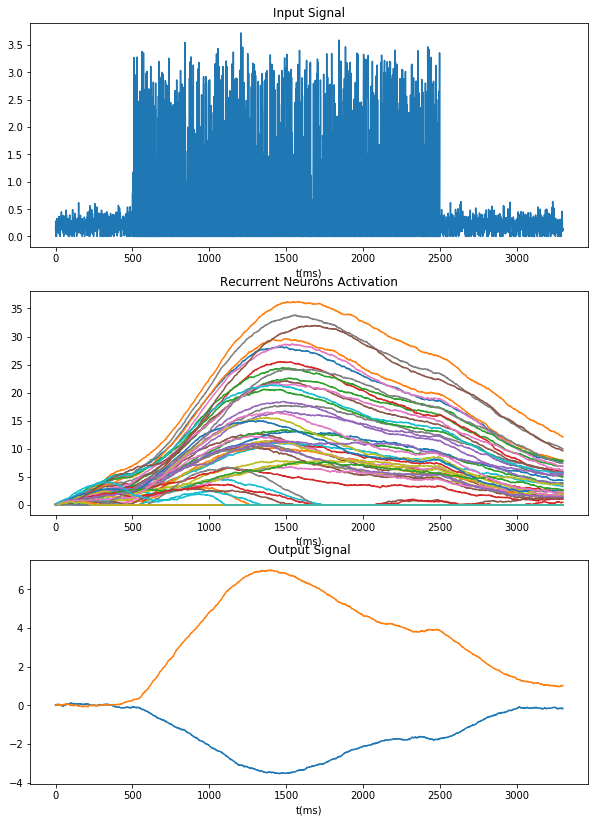

In [280]:
plt.figure(figsize=(10,14))
plt.subplot(311)
plt.plot(rnn.t, rnn.u[0])
plt.title('Input Signal')
plt.xlabel('t(ms)')

plt.subplot(312)
#plt.imshow(rnn.r, aspect='auto')
plt.plot(np.transpose(rnn.r))
plt.xlabel('t(ms)')
plt.title('Recurrent Neurons Activation')

plt.subplot(313)
plt.plot(rnn.t, rnn.z[0])
plt.plot(rnn.t, rnn.z[1])
plt.title('Output Signal')
plt.xlabel('t(ms)')

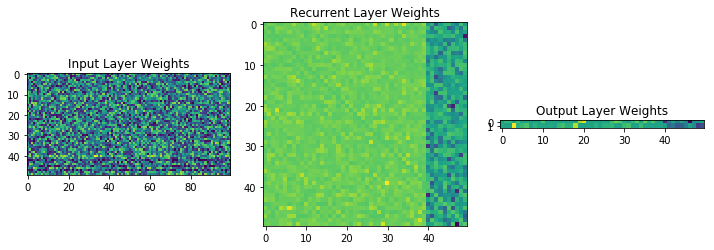

In [325]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.subplot(131)
plt.imshow(rnn.Win, aspect='equal')
plt.title('Input Layer Weights')

plt.subplot(132)
plt.imshow(rnn.Wrec, aspect='equal')
plt.title('Recurrent Layer Weights')


plt.subplot(133)
plt.imshow(rnn.Wout, aspect='equal')
plt.title('Output Layer Weights')

plt.tight_layout(pad = 1)